In [23]:
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [24]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 

dataset_fname = 'bursi.pos.gspan'

In [25]:
%%time
# induce a grammar and train an estimator
training_graphs = get_graphs(dataset_fname, size=200)

from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
sampler=GraphLearnSampler(radius_list=[0,1,2,3,4], thickness_list=[2,3],random_state=42,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(5))
#take nu% of data as outlier
sampler.fit(training_graphs, nu=0.2, n_jobs=-1)

print('graph grammar stats:')
n_instances, n_interfaces, n_cores, n_cips = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances,
                                                                                     n_interfaces,
                                                                                     n_cores,
                                                                                     n_cips))

graph grammar stats:
#instances: 200   #interfaces: 661   #cores: 858   #core-interface-pairs: 2551
CPU times: user 17.5 s, sys: 2.25 s, total: 19.8 s
Wall time: 32.5 s


In [35]:
%%time
# graph sampling
graphs = get_graphs(dataset_fname, size=1000)

id_start=0
id_end=id_start+4*10
from itertools import islice
graphs = islice(graphs,id_start,id_end)

# sample
n_steps=500
n_samples=6

from graphlearn.graphlearn import GraphLearnSampler
graphs = sampler.sample(graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=True,
                        probabilistic_core_choice=False,
                        score_core_choice= False,
                        max_core_size_diff=1,
                        burnin=450,
                        omit_seed=False,
                        max_cycle_size=6,
                        improving_threshold=0.5, 
                        accept_static_penalty=0,
                        n_jobs=-1,
                        select_cip_max_tries=200,
                        keep_duplicates=False)

CPU times: user 25 µs, sys: 6 µs, total: 31 µs
Wall time: 30 µs


Graph id: 0


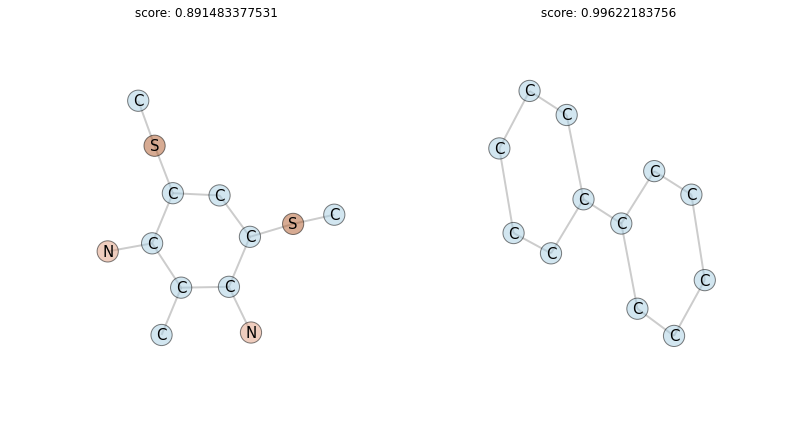

Graph id: 1


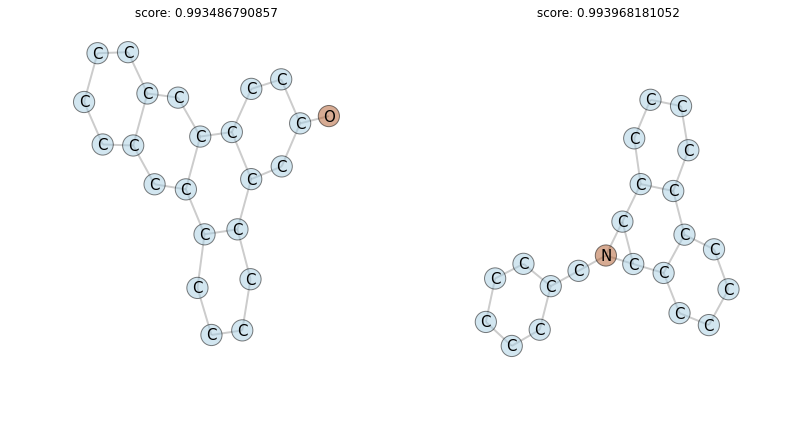

Graph id: 2


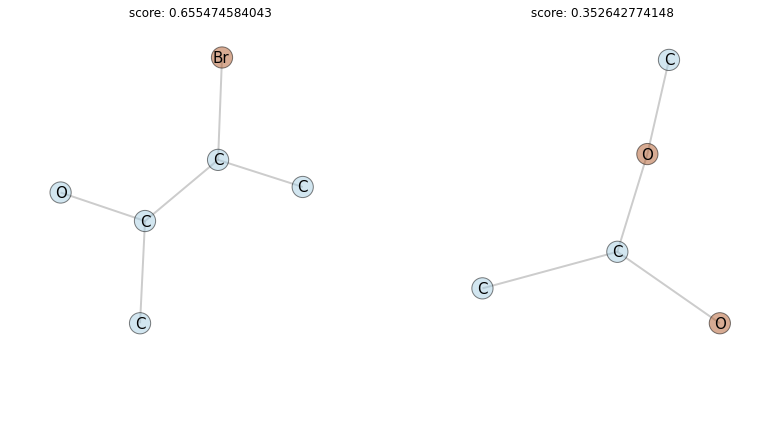

Graph id: 3


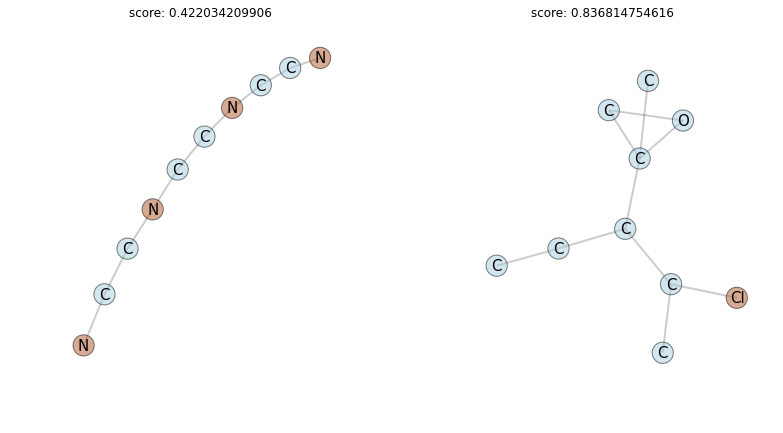

Graph id: 4


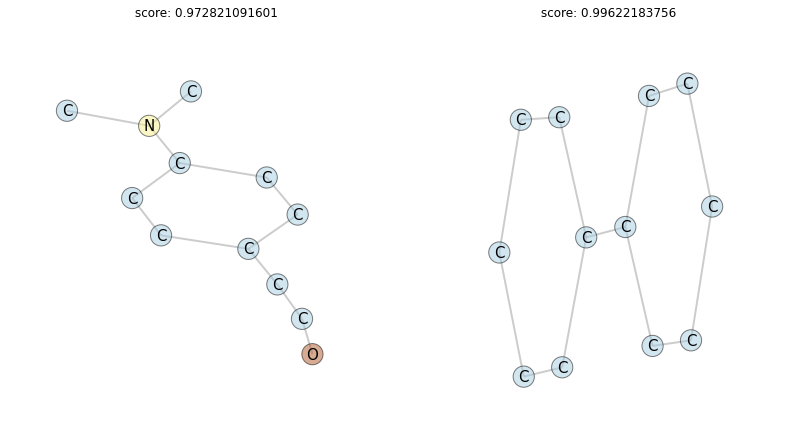

Graph id: 5


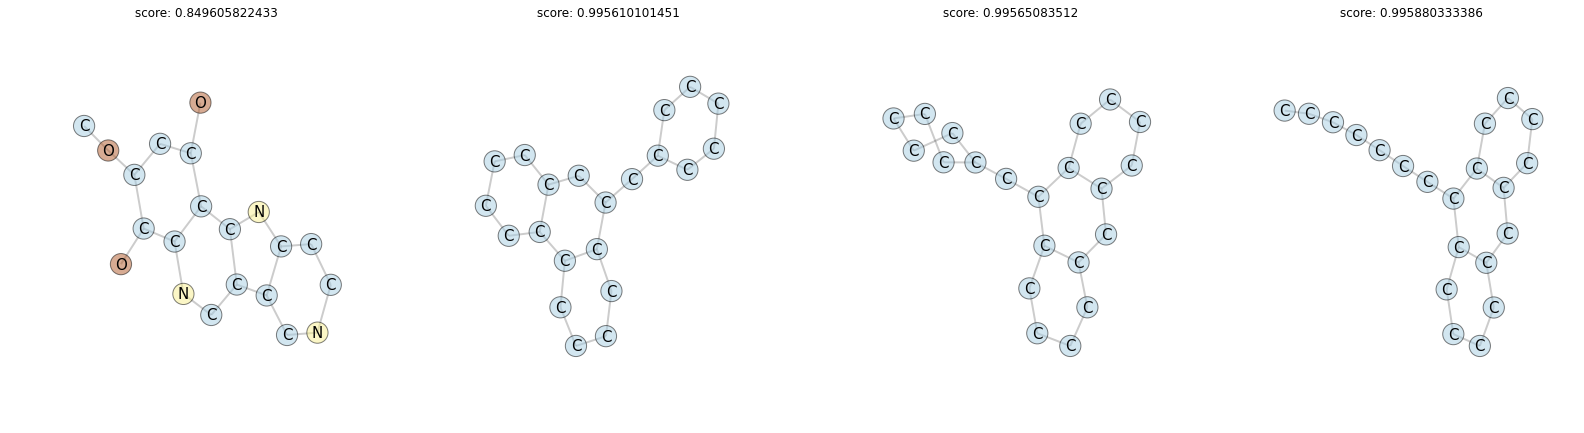

Graph id: 6


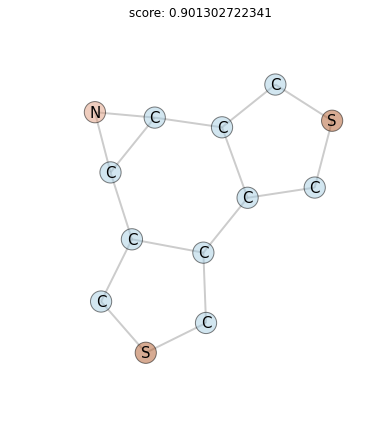

Graph id: 7


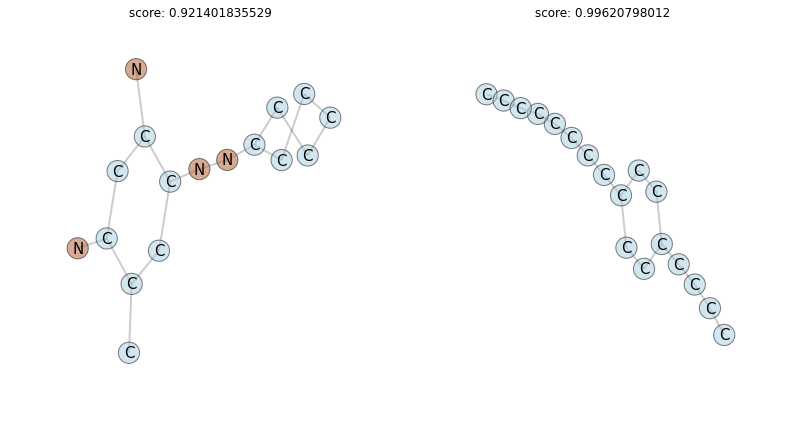

Graph id: 8


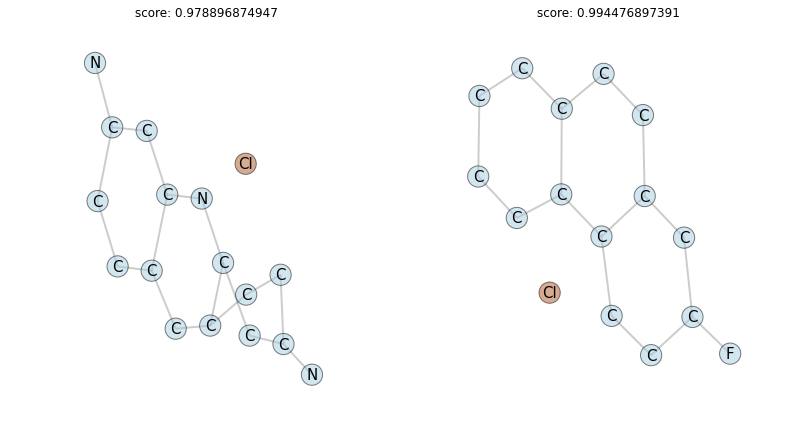

Graph id: 9


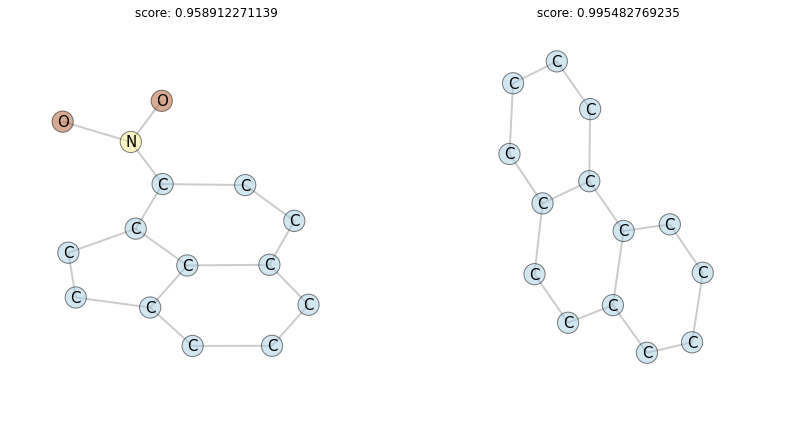

Graph id: 10


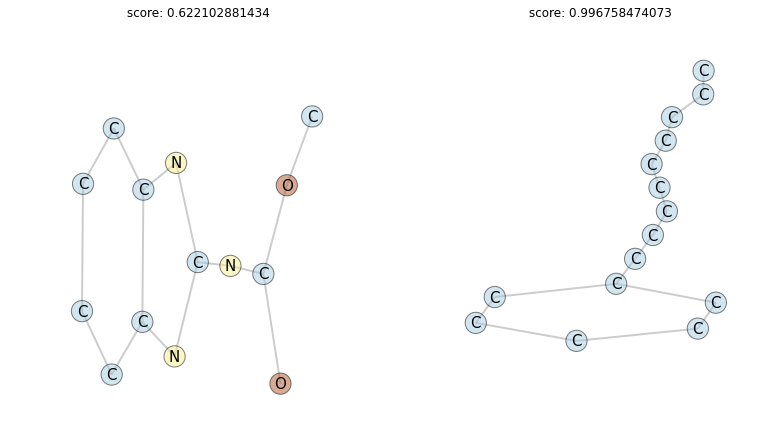

Graph id: 11


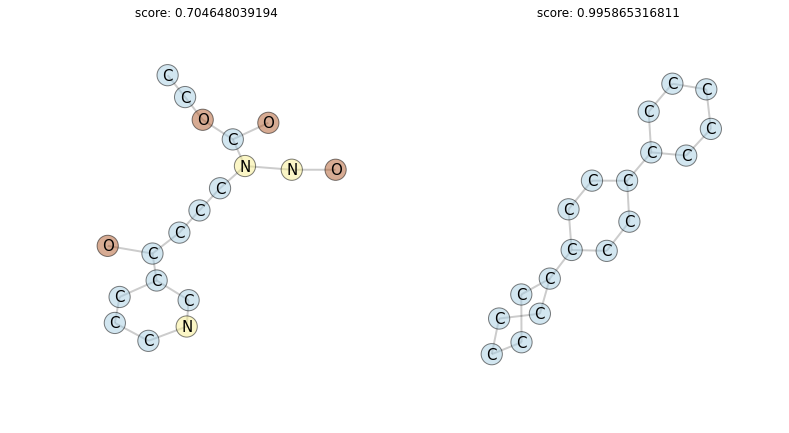

Graph id: 12


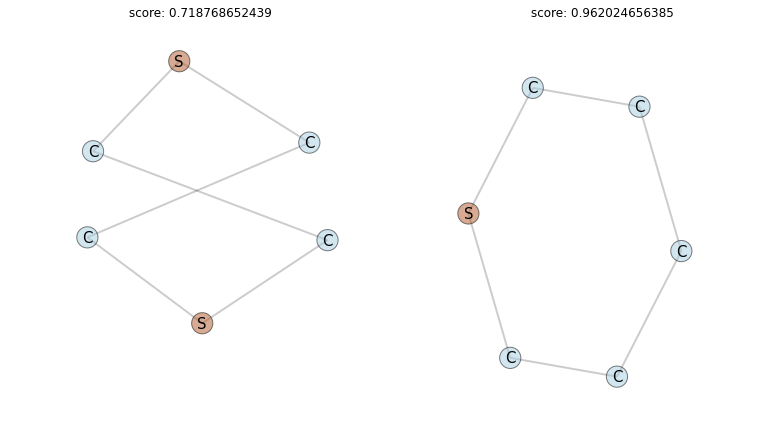

Graph id: 13


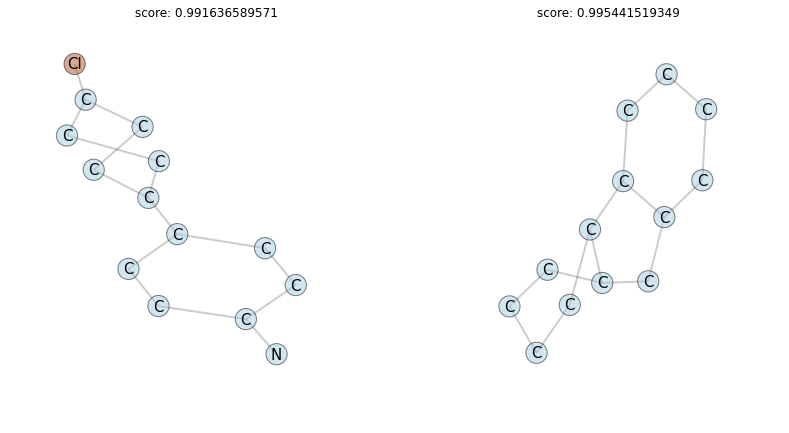

Graph id: 14


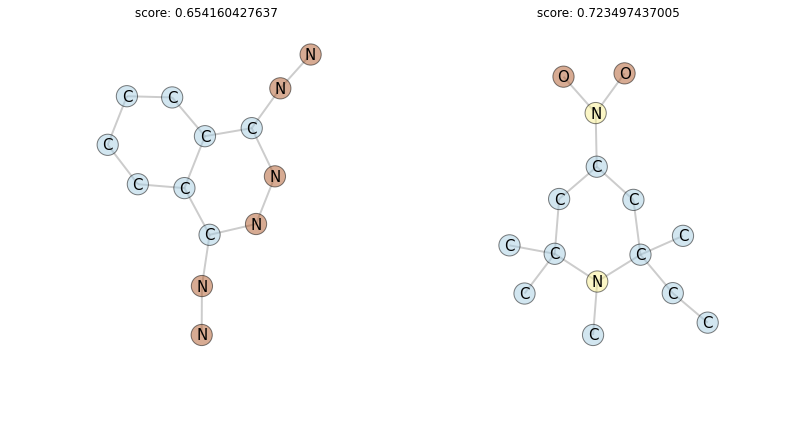

Graph id: 15


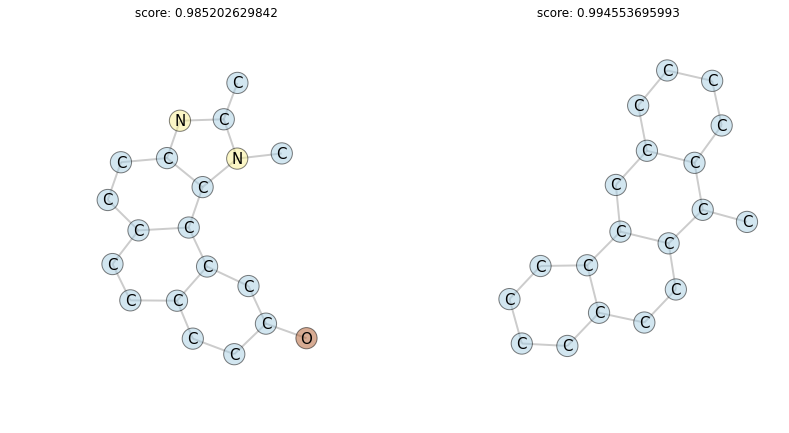

Graph id: 16


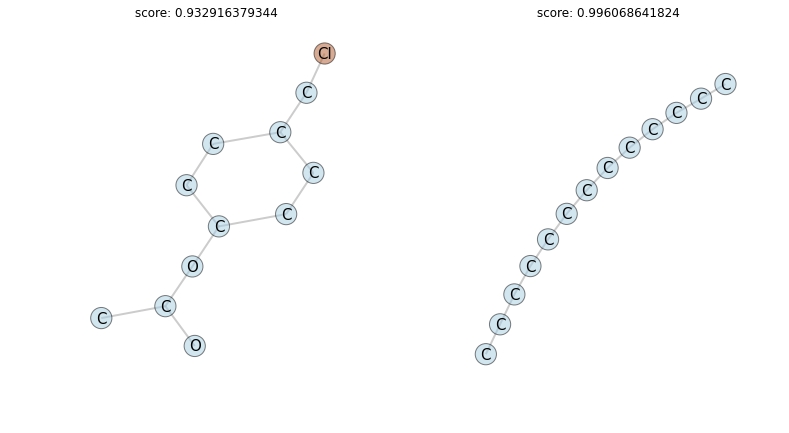

Graph id: 17


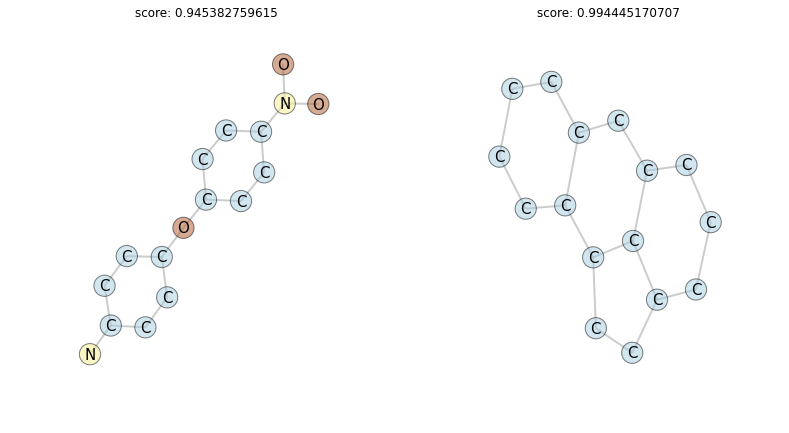

Graph id: 18


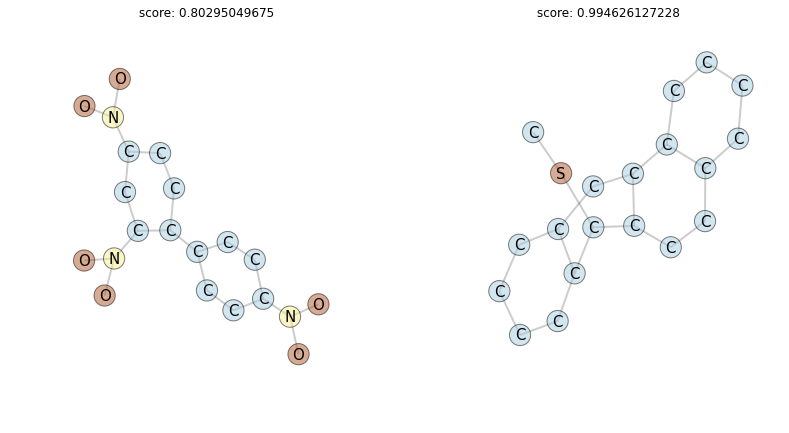

Graph id: 19


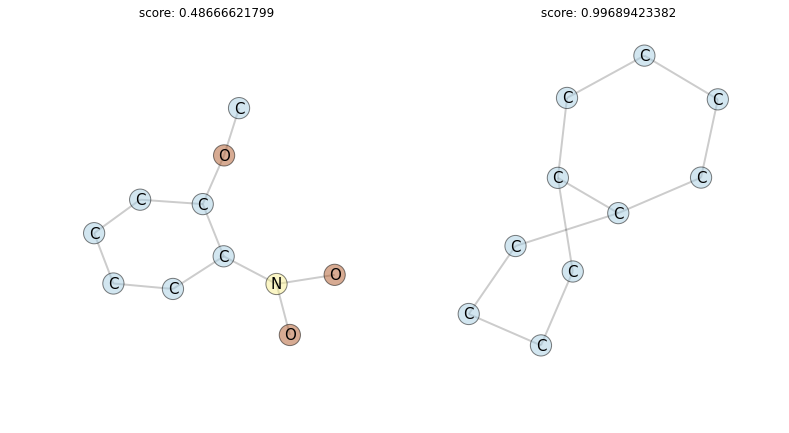

Graph id: 20


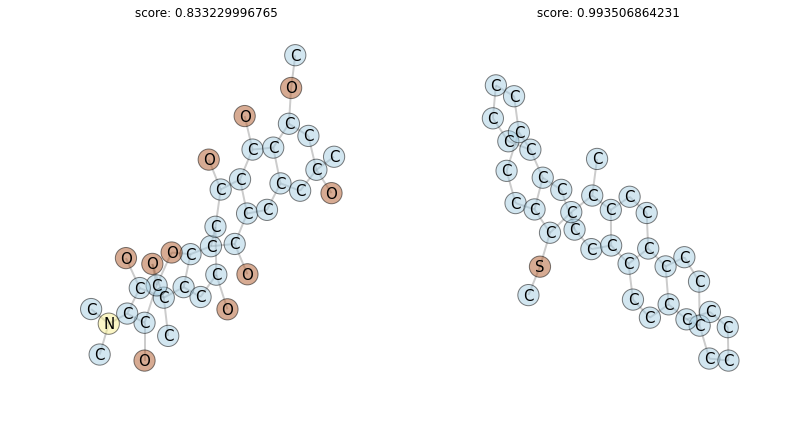

Graph id: 21


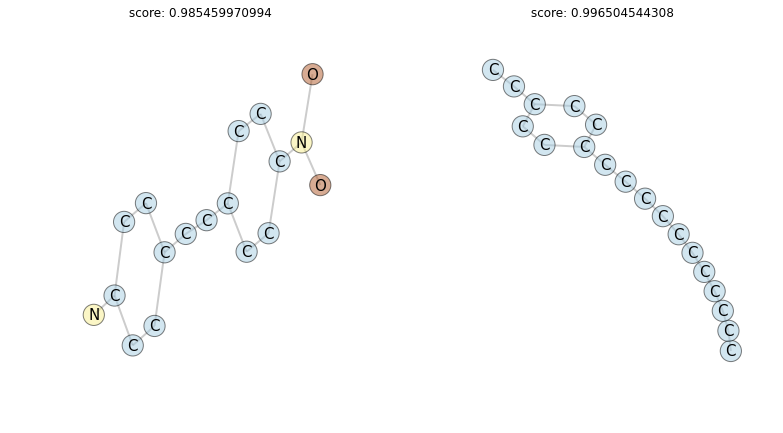

Graph id: 22


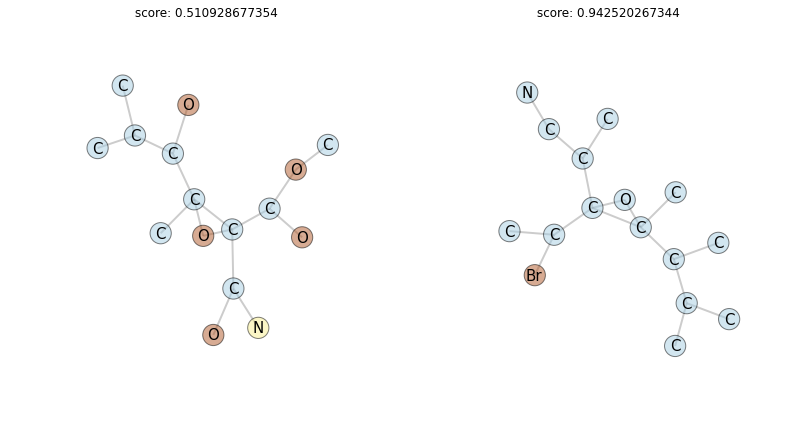

Graph id: 23


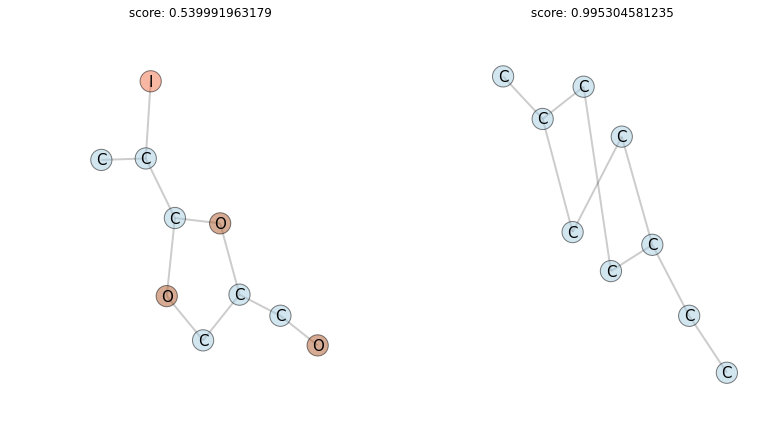

Graph id: 24


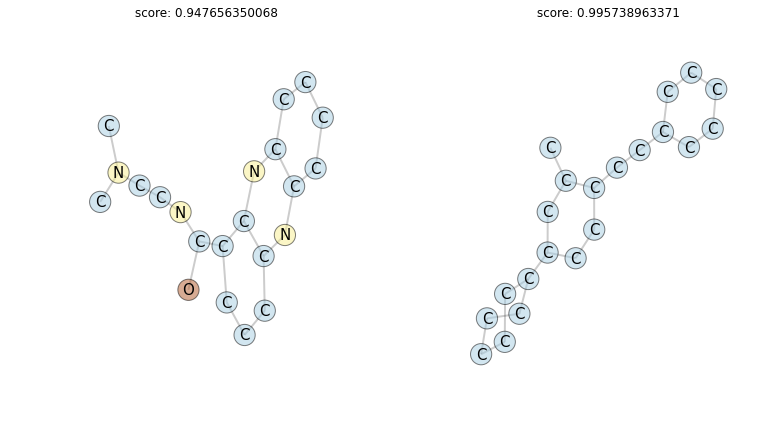

Graph id: 25


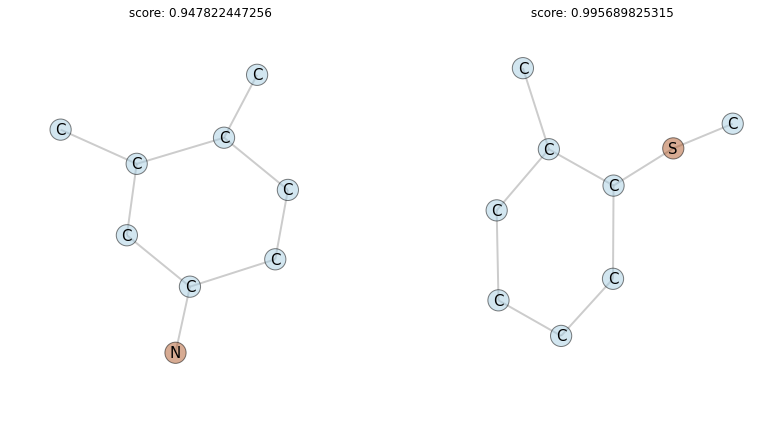

Graph id: 26


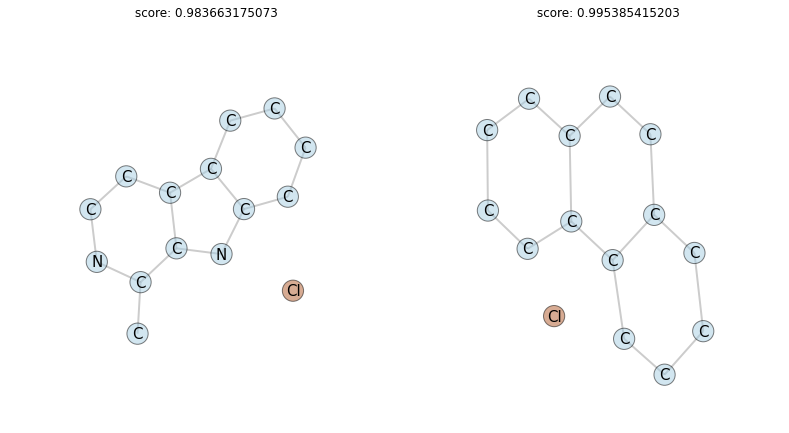

Graph id: 27


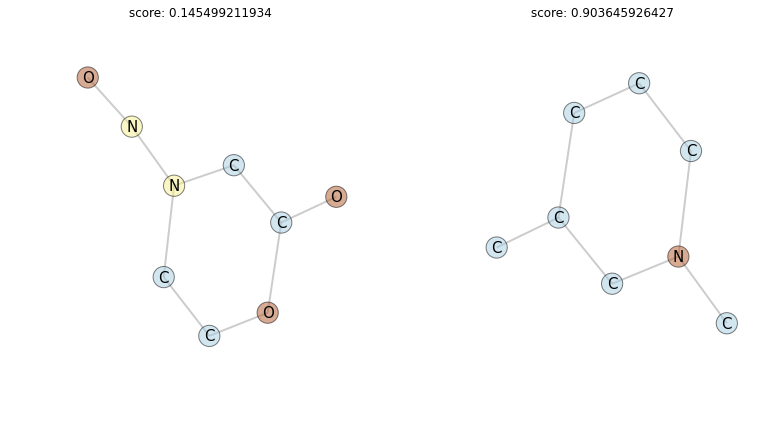

Graph id: 28


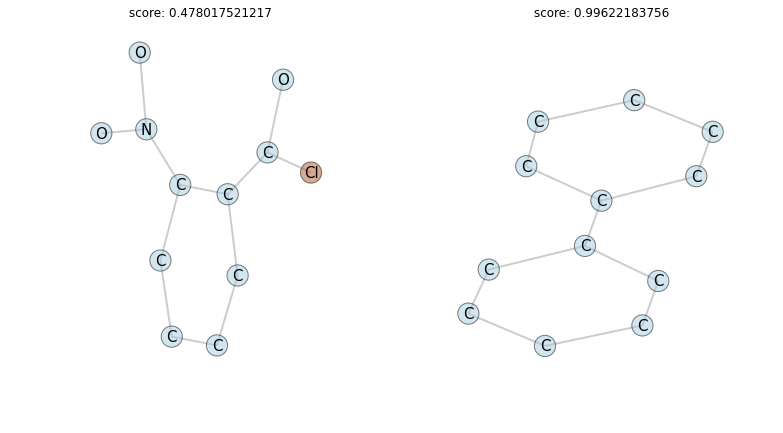

Graph id: 29


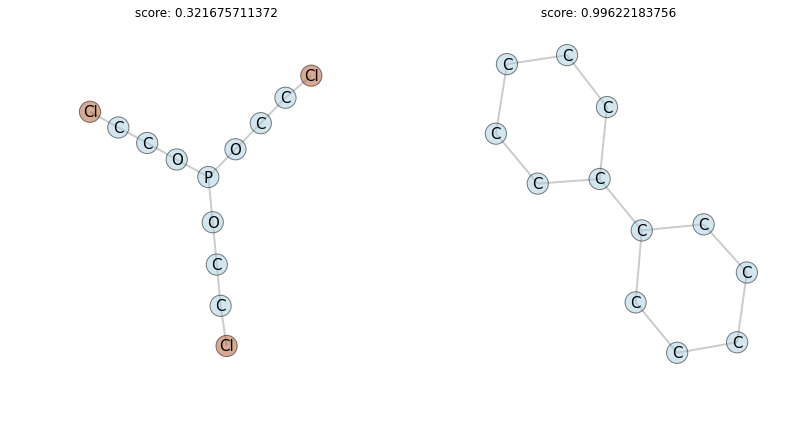

Graph id: 30


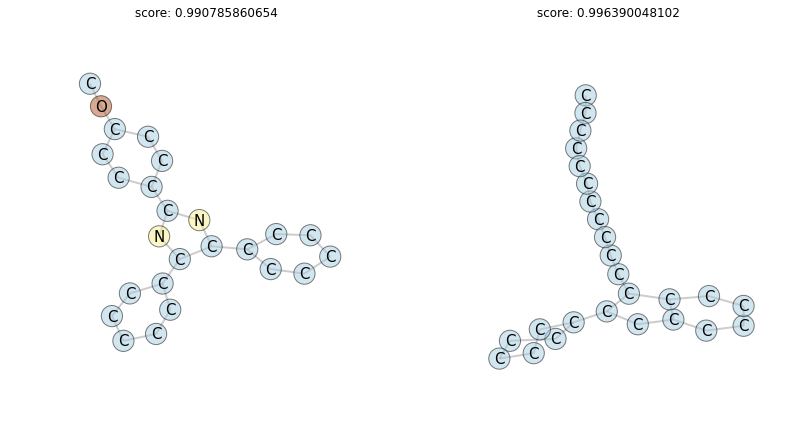

Graph id: 31


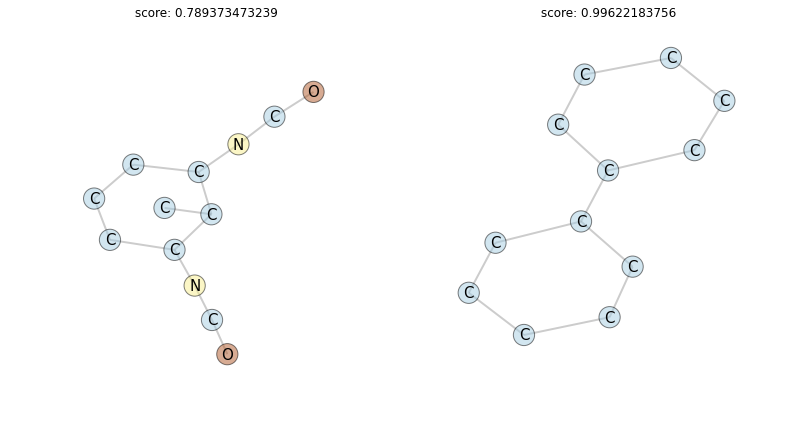

Graph id: 32


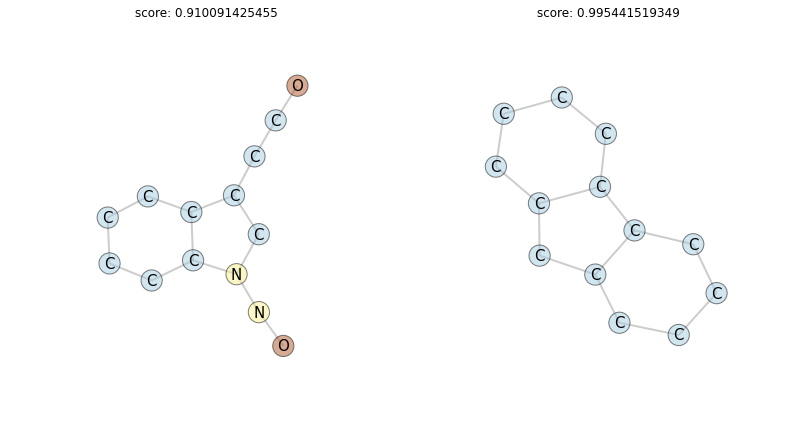

Graph id: 33


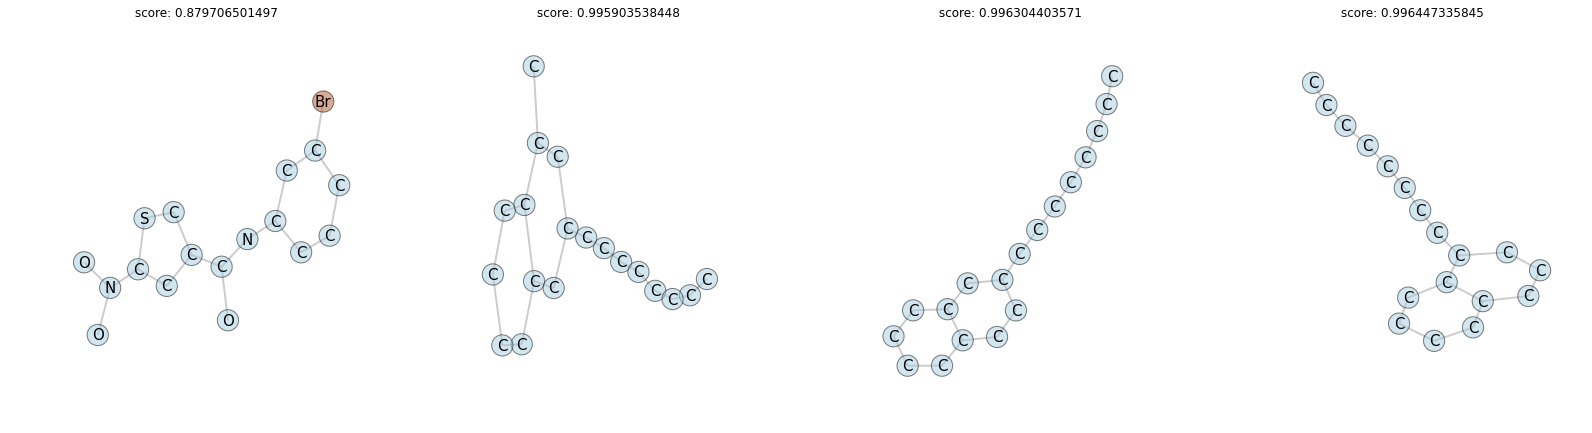

Graph id: 34


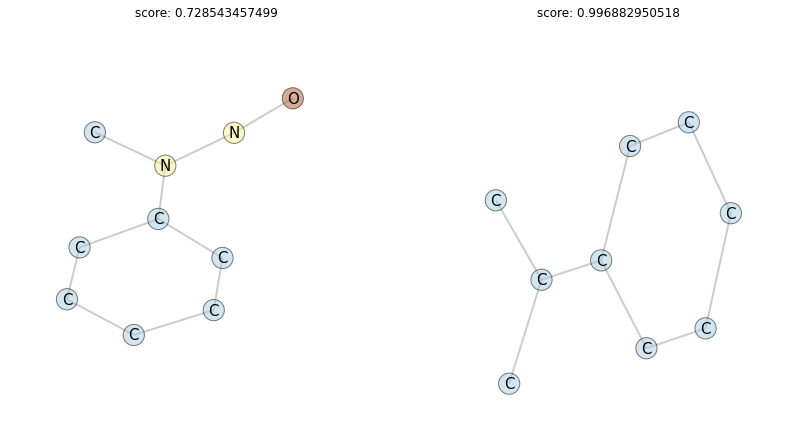

Graph id: 35


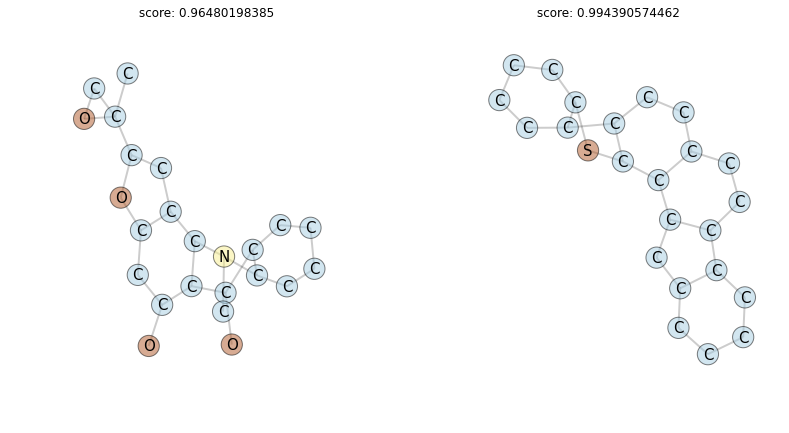

Graph id: 36


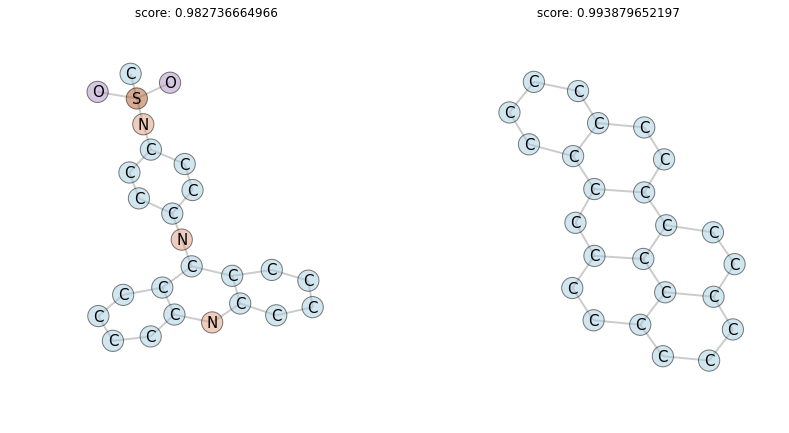

Graph id: 37


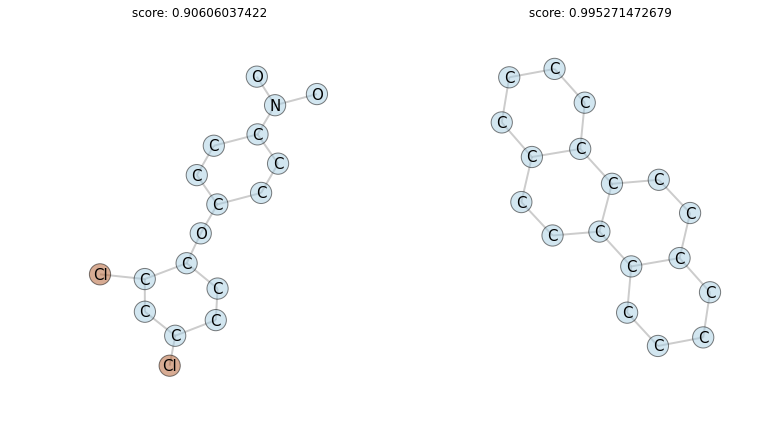

Graph id: 38


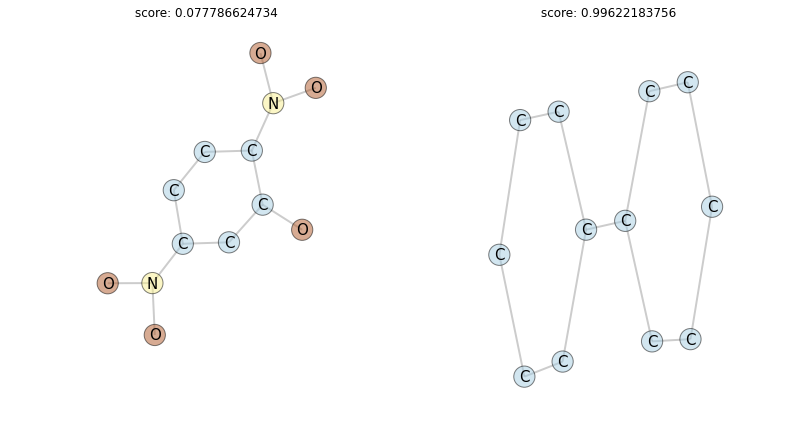

Graph id: 39


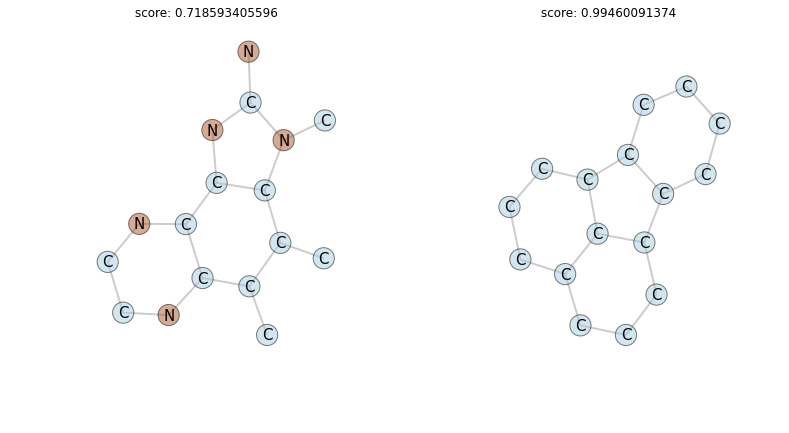

CPU times: user 35 s, sys: 3.59 s, total: 38.6 s
Wall time: 16min 18s


In [36]:
%%time
# plot examples of sampling paths
from graphlearn.utils.draw import  graphlearn_draw, get_score_of_graph
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    graphlearn_draw(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450,
                   headlinehook=get_score_of_graph)

CPU times: user 2.87 s, sys: 80.9 ms, total: 2.95 s
Wall time: 2.99 s


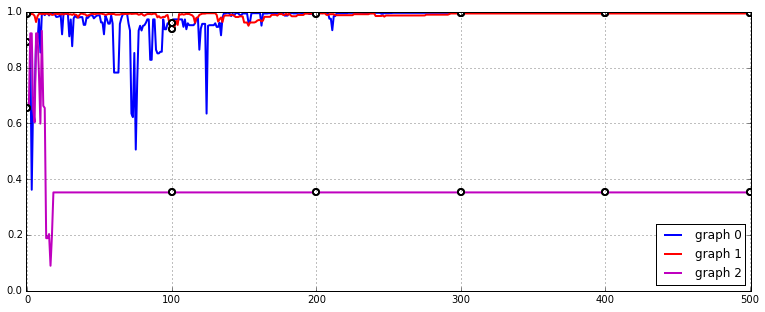

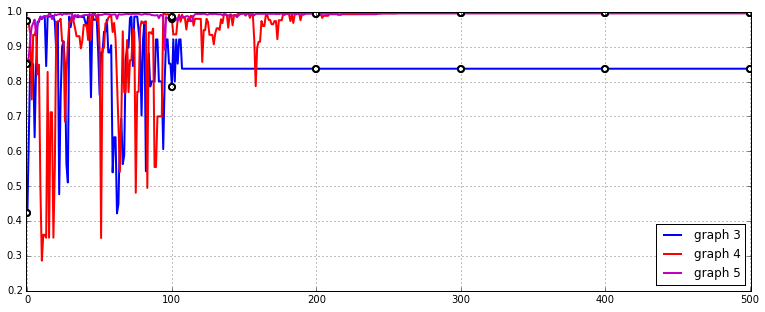

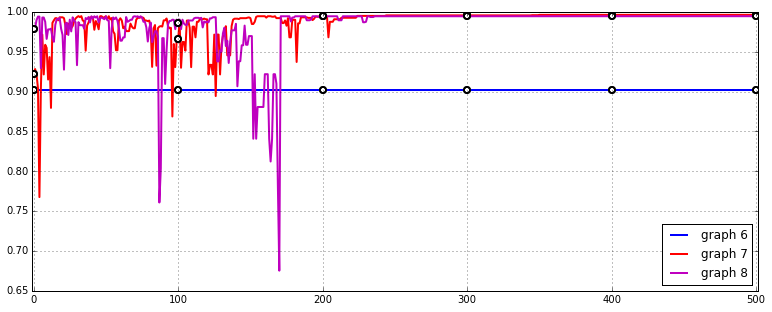

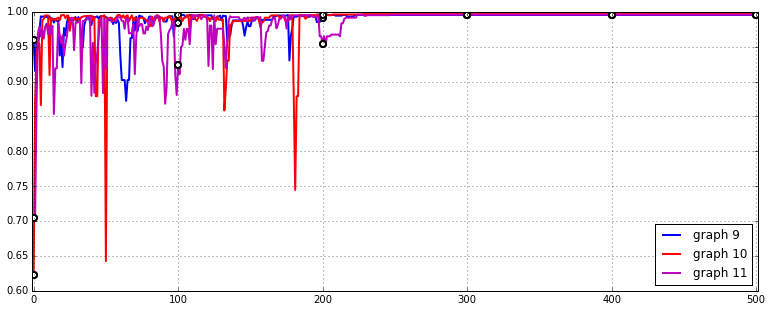

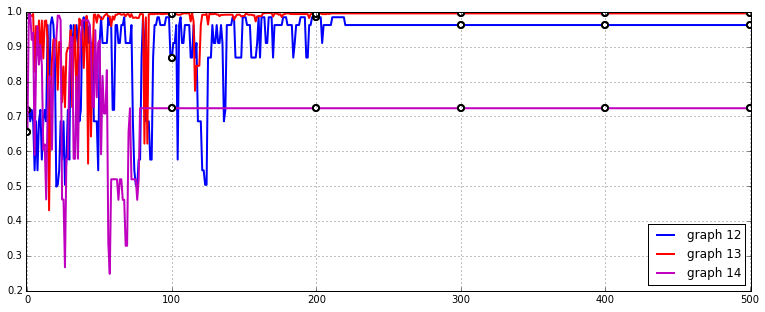

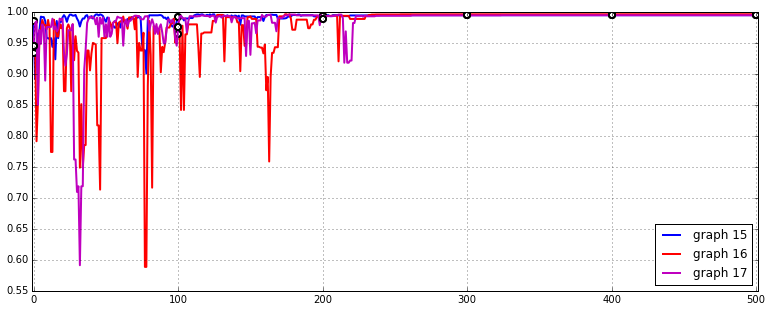

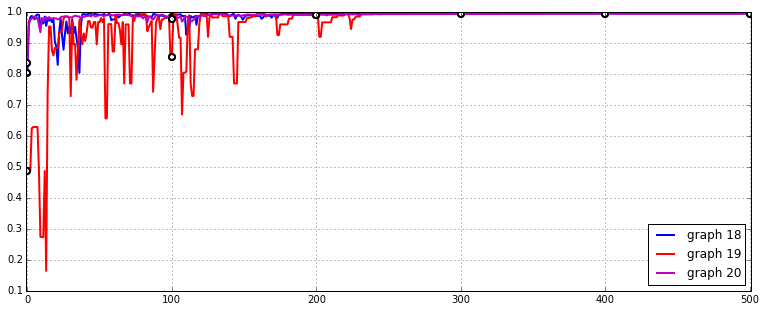

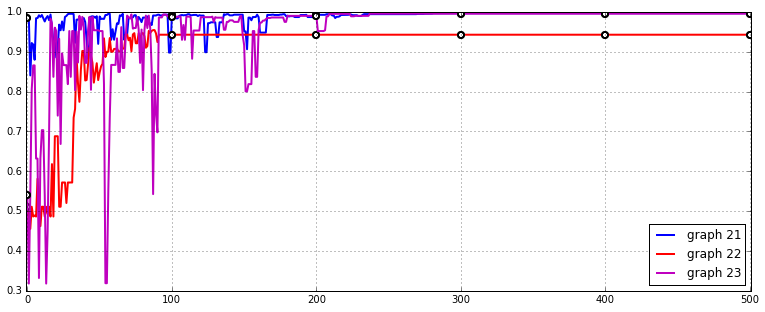

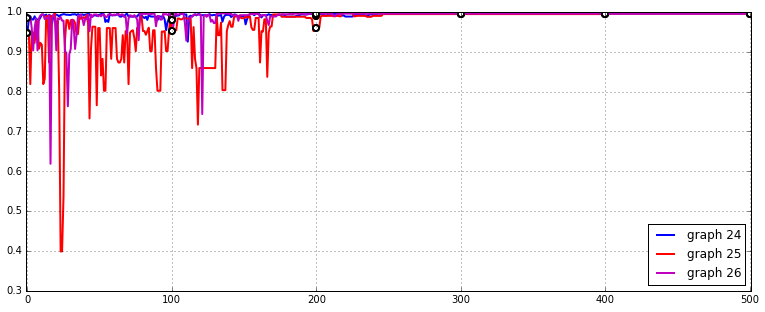

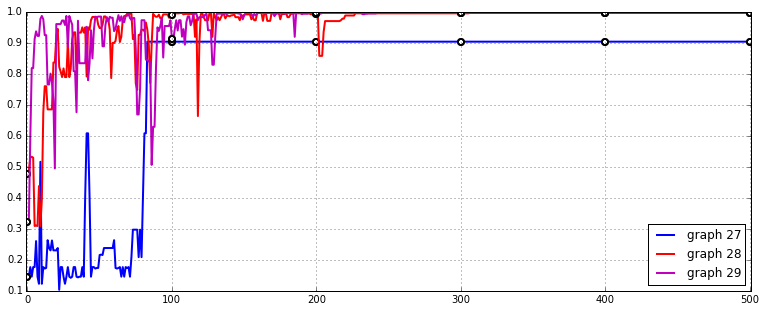

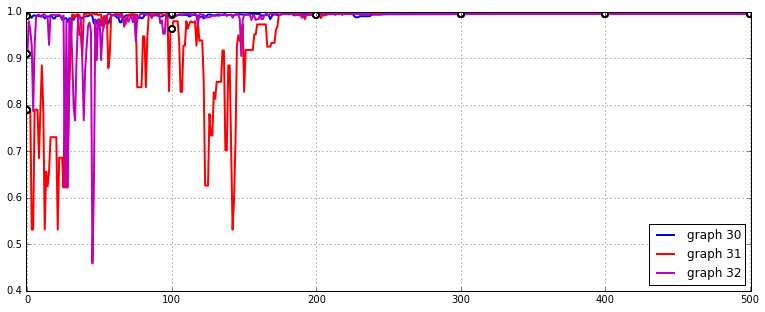

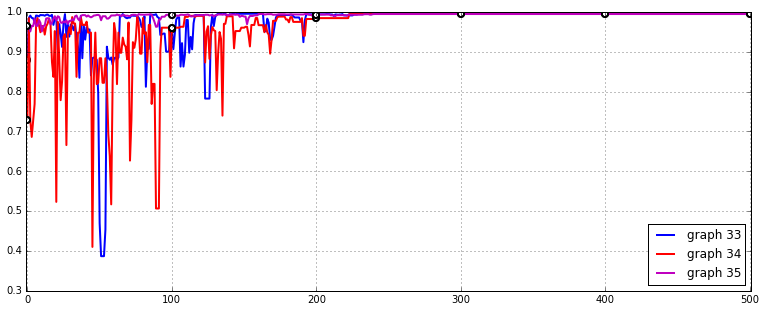

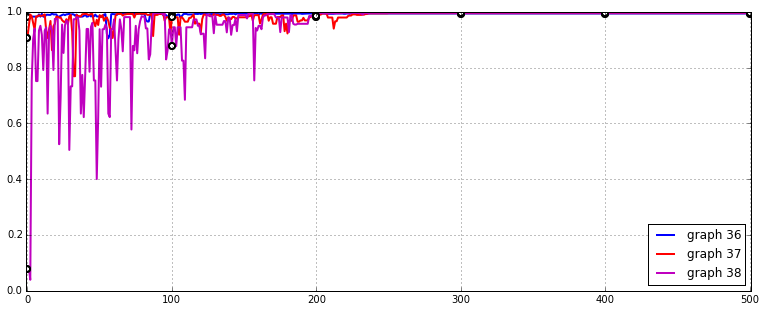

In [43]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples-1)
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',
                 markevery=markevery, 
                 markerfacecolor='white', 
                 marker='o', 
                 markeredgewidth=2,
                 markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    #plt.xlim(-1,300)
    #plt.ylim(.7,1)
    #plt.ylim(-0.1,1.1)
    if False:
        plt.show()
    else:
        plt.savefig('sample_path_%d.pdf' % i)

.